### **Librerias**

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pycaret
pd.options.display.max_rows = 20
import warnings
warnings.filterwarnings('ignore')

## **Etapa 0: Crear Data Set**

### PIB

In [198]:
PIB = pd.read_csv('./Datos/PIB.csv', sep=',',encoding='latin-1')
PIB = PIB[(PIB['year']>=2000) & (PIB['year']<=2020)]
PIB['year'] = PIB['year'].astype('int')
PIB['key'] = [(str((PIB.iloc[i,4])).lower()+'-'+str(PIB.iloc[i,6])) for i in range(len(PIB['country_name']))]
PIB = PIB.sort_values(by=['country_name'])
PIB.shape

(4410, 11)

### Complejidad Economica

In [199]:
Data_ECI = pd.read_csv('./Datos/ECI_Data.csv',sep=',',encoding='latin-1')
Data_ECI = Data_ECI.transpose()
Data_ECI = Data_ECI[2:].transpose()
Data_ECI.dropna(inplace=True)

In [200]:
complexity = []
pais = []
año = []
for i in range(len(Data_ECI.iloc[:,:0])):
    for j in range(len(Data_ECI.iloc[0,:-3])):
        pais.append(Data_ECI.iloc[i,22])
        año.append((Data_ECI.columns[j]))
        complexity.append(Data_ECI.iloc[i,j])
ECI = pd.DataFrame()
ECI['Pais'] = pais
ECI['ECI'] = complexity
ECI['año'] = año
ECI['año'] = ECI['año'].astype('int')
ECI['key'] = [(str(ECI.iloc[i,0]).lower()+'-'+str(ECI.iloc[i,2])) for i in range(len(ECI['año']))]
ECI = ECI.sort_values(by=['Pais'])
ECI.shape

(1953, 4)

### Poblacion

In [201]:
Data_Poblacion = pd.read_csv('./Datos/Poblacion_Data.csv', sep=',',encoding='latin-1')
Data_Poblacion.dropna(inplace=True)

In [202]:
Poblacion = []
pais_p = []
año = []
for i in range(len(Data_Poblacion.iloc[:,:0])):
    for j in range(len(Data_Poblacion.iloc[0,4:-2])):
        pais_p.append(Data_Poblacion.iloc[i,0])
        año.append(int(Data_Poblacion.columns[j+4]))
        Poblacion.append(Data_Poblacion.iloc[i,j+4])
Population = pd.DataFrame()
Population['Pais'] = pais_p
Population['Poblacion'] = Poblacion
Population['año'] = año
Population['key'] = [(str(Population.iloc[i,0]).lower()+'-'+str(Population.iloc[i,2])) for i in range(len(Population['año']))]
Population = Population.sort_values(by=['Pais'])

### Region

In [203]:
cordenada = pd.read_csv('./Datos/country-coord.csv', sep=',',encoding='latin-1')
cordenada['country'] = [(str(cordenada.iloc[i,0]).lower()) for i in range(len(cordenada['Country']))]
cordenada.shape

(244, 4)

In [204]:
cordenada.iloc[0,2]

65.0

In [205]:
cordenada['Ecuador'] = [1 if (cordenada.iloc[i,1]<=27 and cordenada.iloc[i,1]>=-27) else 0 for i in range(len(cordenada['country']))]

### Union DataFrames

In [218]:
Data_final = PIB.merge(Population,left_on='key',right_on='key').merge(ECI,left_on='key',right_on='key')
Data_final = Data_final[['Pais_x', 'Poblacion', 'total_gdp_million','ECI','año_x']]
Data_final['country'] = [(str(Data_final.iloc[i,0]).lower()) for i in range(len(Data_final['Pais_x']))]
Data_final = pd.merge(Data_final, cordenada, on ='country', how ='inner')
Data_final = Data_final[['Pais_x', 'Poblacion', 'total_gdp_million','ECI','año_x','Ecuador']]
Data_final.to_csv('Datos/Crecimiento_ec.csv')

## **Etapa 1: Entender los Datos**

In [276]:
Data = pd.read_csv('./Datos/Crecimiento_ec.csv')
Data.drop('Unnamed: 0',axis=1,inplace=True)
Data['año'] = ["".join([str(Data.iloc[i,4]),"-01"]) for i in range(len(Data.año_x))]
Data

,Pais_x,Poblacion,total_gdp_million,ECI,año_x,Ecuador,año
0,Algeria,42705368.0,171767.403700,-1.042459,2019,0,2019-01
1,Algeria,43451666.0,145009.181500,-1.206390,2020,0,2020-01
2,Algeria,30774621.0,54790.392750,-1.064802,2000,0,2000-01
3,Algeria,31200985.0,54744.712810,-0.804064,2001,0,2001-01
4,Algeria,31624696.0,56760.355870,-0.994074,2002,0,2002-01
...,...,...,...,...,...,...,...
1570,Zimbabwe,11984644.0,6342.116400,-0.342388,2002,1,2002-01
1571,Zimbabwe,11910978.0,6777.384700,-0.393783,2001,1,2001-01
1572,Zimbabwe,11834676.0,6689.957600,-0.288579,2000,1,2000-01
1573,Zimbabwe,12679810.0,9665.793264,-0.381771,2009,1,2009-01


In [331]:
Data.head(5)

,Pais_x,Poblacion,total_gdp_million,ECI,año_x,Ecuador,año
0,Algeria,42705368.0,171767.40370,-1.042459,2019,0,2019-01
1,Algeria,43451666.0,145009.18150,-1.206390,2020,0,2020-01
2,Algeria,30774621.0,54790.39275,-1.064802,2000,0,2000-01
3,Algeria,31200985.0,54744.71281,-0.804064,2001,0,2001-01
4,Algeria,31624696.0,56760.35587,-0.994074,2002,0,2002-01


In [332]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pais_x             1575 non-null   object 
 1   Poblacion          1575 non-null   float64
 2   total_gdp_million  1575 non-null   float64
 3   ECI                1575 non-null   float64
 4   año_x              1575 non-null   int64  
 5   Ecuador            1575 non-null   int64  
 6   año                1575 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 86.3+ KB


In [233]:
def timeline(columna):
    time = pd.pivot_table(Data,values=columna,columns=['año_x'],aggfunc='mean')
    return time
    

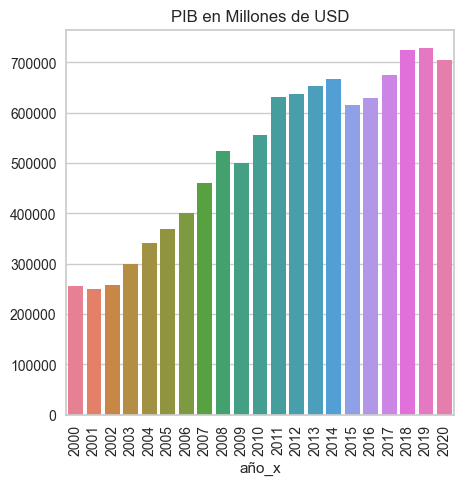

In [237]:
fig,ax = plt.subplots(1,sharex=True,figsize=(5,5))
ax = sns.barplot(timeline('total_gdp_million'))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('PIB en Millones de USD')
plt.show()

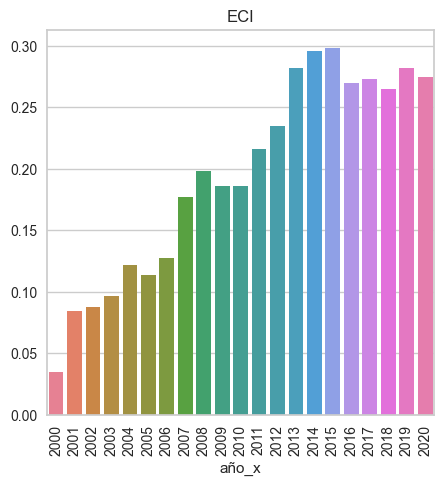

In [238]:
fig,ax = plt.subplots(1,sharex=True,figsize=(5,5))
ax = sns.barplot(timeline('ECI'))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('ECI')
plt.show()

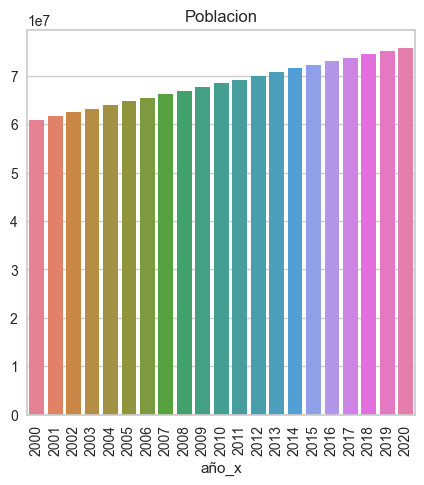

In [239]:
fig,ax = plt.subplots(1,sharex=True,figsize=(5, 5))
ax = sns.barplot(timeline('Poblacion'))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Poblacion')
plt.show()

In [240]:
print(f'Hay un total de {len(Data.Pais_x.unique())} paises con los cuales trabajar')

Hay un total de 75 paises con los cuales trabajar


## **Etapa 2: Revisar problemas en Series de Tiempo**

In [ ]:
from pycaret.regression import *
from pycaret.regression import RegressionExperiment
from statsmodels.stats.outliers_influence import variance_inflation_factor
exp = RegressionExperiment()

In [ ]:
X = Data_final[['Poblacion', 'ECI', 'año_x', 'Ecuador']]
Y = Data_final['total_gdp_million']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

### ***Revisar Multicolinealidad***

In [ ]:
variables = Data_final.drop(columns=['Pais_x'])
vif_data = pd.DataFrame()
vif_data["Variable"] = variables.columns
vif_data["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

In [ ]:
print("\nVIF:")
print(vif_data)


VIF:
            Variable       VIF
0          Poblacion  1.781558
1  total_gdp_million  2.157813
2                ECI  1.609753
3              año_x  2.499387
4            Ecuador  2.434782


Existe multicolinealidad leve entre los datos entre los datos, por lo que no necesariamente se debe eliminarla pues al ser una multicolinalidad moderada el modelo de regresion lineal puede seguir haciendo predicciones de manera correcta

### ***Revisar Autocorrelacion***

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics import tsaplots
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller

In [ ]:
X = np.array(Data_final.ECI)

In [ ]:
sm.tsa.acf (X)

array([ 1.        ,  0.93415228,  0.8822679 ,  0.83326927,  0.77894522,
        0.73213627,  0.68247589,  0.63280588,  0.58410197,  0.53776899,
        0.48695291,  0.43925635,  0.38624893,  0.33911762,  0.29653167,
        0.25193233,  0.20665067,  0.16616246,  0.12236616,  0.07985138,
        0.0391977 , -0.00415941, -0.00252875,  0.00209584,  0.00827472,
        0.0129243 ,  0.01555542,  0.02091416,  0.02548139,  0.03079507,
        0.03464726,  0.03835648])

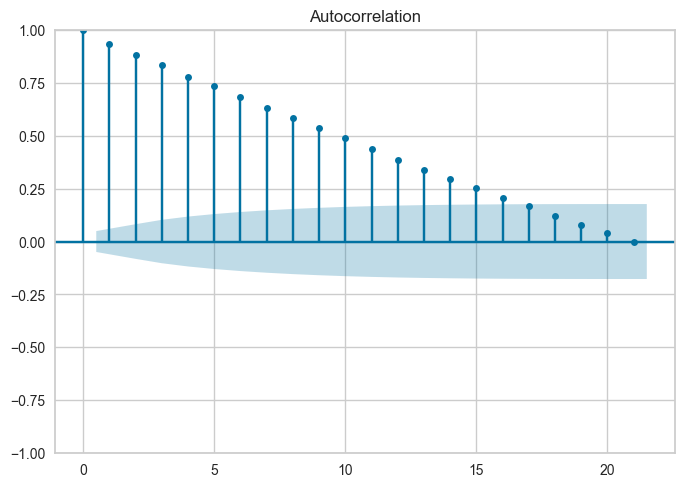

In [ ]:
fig = tsaplots.plot_acf(X,lags=21)
plt.show ()

In [ ]:
model_1 = ols('total_gdp_million ~ Poblacion + ECI + Ecuador', data=Data_final).fit()
durbin_watson(model_1.resid)

0.28431927577944044

In [ ]:
model_2 = ols('total_gdp_million ~ Poblacion + Ecuador ', data=Data_final).fit()
durbin_watson(model_2.resid)

0.273151820843164

In [ ]:
model_3 = ols('total_gdp_million ~ ECI + Poblacion ', data=Data_final).fit()
durbin_watson(model_3.resid)

0.28239224817242775

* En este caso se observa que el modelo muestra autocorrelacion pues se trata de Datos de panel los cuales tienen una componente temporal, en este caso la prueba de DurbiWatson para los 3 modelos arroja el valor de ***ρ*** cercado a 0 [0.28,0.27,1.8] entrando en el rango de 0<***ρ***<1 dando un DW = 2 (Durbin Watson) dando como resultado que el dataset tiene autocorrelacion positiva , lo que se refuerza al ver la grafica la cual solo en el rezago 21 tiene autocorrelacion de 0, mietras que a lo largo de la grafica siempre se observo que la autocorrelacion fue bajando pocco a poco.

* El problema de que exista autocorrelacion es que el modelo al usar regresion lineal tendra problemas a la hora ajsutar el modelo pues puede generar un Coeficiente de Determinacion muy perfecto R<sup>2</sup>=1, lo que haria que existe overfitting en el modelo imposibilidanto la generalizacion de los datos.


### ***Revisar Estacionariedad***

In [356]:
import plotly.express as px
Data_glob = pd.pivot_table(Data,index='año',values=['total_gdp_million'],aggfunc='sum').reset_index()
Data_glob['Time'] = pd.to_datetime(Data_glob['año'])
Data_glob = Data_glob.sort_values(by='Time')
fig = px.line(Data_glob, x="Time", y=["total_gdp_million"], template = 'plotly_dark')
fig.show()

In [355]:
D_fuller = adfuller(Data_glob.total_gdp_million,autolag='AIC')
print(f'El Estadistico D-Fuller es: {D_fuller[0]}')
print(f'El p-valor es de: {D_fuller[1]}')

El Estadistico D-Fuller es: -1.1793378898436
El p-valor es de: 0.6824202844756094


El valor de p > 0.05 NO rechaza la hipotesis Nula, por lo que se puede decir que la serie de tiempo NO tiene un comportamiento estacional

### ***Eliminar Autocorrelacion***

## **Etapa 3: Crear y Evaluar Modelos con Pycaret**

### ***Data***

In [ ]:
std = StandardScaler()
std.fit(Data_final[['total_gdp_million']])
Data_final['total_gdp_million']= std.transform(Data_final[['total_gdp_million']])
std.fit(Data_final[['Poblacion']])
Data_final['Poblacion']= std.transform(Data_final[['Poblacion']])
Data_final.drop(columns=['Pais_x'],axis=1,inplace =True)
Data_final

,Poblacion,total_gdp_million,ECI,año_x,Ecuador
0,-0.123399,-0.283150,-1.042459,2019,0
1,-0.119818,-0.305020,-1.206390,2020,0
2,-0.180644,-0.378758,-1.064802,2000,0
3,-0.178598,-0.378796,-0.804064,2001,0
4,-0.176565,-0.377148,-0.994074,2002,0
...,...,...,...,...,...
1570,-0.270800,-0.418356,-0.342388,2002,1
1571,-0.271153,-0.418000,-0.393783,2001,1
1572,-0.271519,-0.418072,-0.288579,2000,1
1573,-0.267464,-0.415640,-0.381771,2009,1


In [ ]:
reg = setup(Data_final, target = 'total_gdp_million', session_id = 123,remove_multicollinearity=True)

,Description,Value
0,Session id,123
1,Target,total_gdp_million
2,Target type,Regression
3,Original data shape,"(1575, 5)"
4,Transformed data shape,"(1575, 5)"
5,Transformed train set shape,"(1102, 5)"
6,Transformed test set shape,"(473, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0444,0.0154,0.1054,0.9853,0.0451,0.3794,0.0200
rf,Random Forest Regressor,0.0776,0.0856,0.2196,0.9183,0.0768,0.4537,0.0260
gbr,Gradient Boosting Regressor,0.1229,0.0815,0.2457,0.9133,0.1087,0.9615,0.0150
lightgbm,Light Gradient Boosting Machine,0.1106,0.1099,0.2921,0.8975,0.1007,0.7146,0.1110
dt,Decision Tree Regressor,0.0963,0.1424,0.3113,0.8301,0.1054,0.5288,0.0050
ada,AdaBoost Regressor,0.3741,0.2601,0.4837,0.6442,0.2147,2.5735,0.0100
br,Bayesian Ridge,0.4093,0.5629,0.7271,0.3295,0.2671,3.2042,0.0040
ridge,Ridge Regression,0.4098,0.5630,0.7273,0.3284,0.2671,3.2143,0.0050
lar,Least Angle Regression,0.4099,0.5631,0.7274,0.3282,0.2671,3.2167,0.0050
lr,Linear Regression,0.4099,0.5631,0.7274,0.3282,0.2671,3.2167,0.0050


In [ ]:
reg = setup(Data_final, target = 'total_gdp_million', session_id = 123,remove_multicollinearity=False)

,Description,Value
0,Session id,123
1,Target,total_gdp_million
2,Target type,Regression
3,Original data shape,"(1575, 5)"
4,Transformed data shape,"(1575, 5)"
5,Transformed train set shape,"(1102, 5)"
6,Transformed test set shape,"(473, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0444,0.0154,0.1054,0.9853,0.0451,0.3794,0.0190
rf,Random Forest Regressor,0.0776,0.0856,0.2196,0.9183,0.0768,0.4537,0.0250
gbr,Gradient Boosting Regressor,0.1229,0.0815,0.2457,0.9133,0.1087,0.9615,0.0150
lightgbm,Light Gradient Boosting Machine,0.1106,0.1099,0.2921,0.8975,0.1007,0.7146,0.1170
dt,Decision Tree Regressor,0.0963,0.1424,0.3113,0.8301,0.1054,0.5288,0.0040
ada,AdaBoost Regressor,0.3741,0.2601,0.4837,0.6442,0.2147,2.5735,0.0120
br,Bayesian Ridge,0.4093,0.5629,0.7271,0.3295,0.2671,3.2042,0.0040
ridge,Ridge Regression,0.4098,0.5630,0.7273,0.3284,0.2671,3.2143,0.0050
lar,Least Angle Regression,0.4099,0.5631,0.7274,0.3282,0.2671,3.2167,0.0040
lr,Linear Regression,0.4099,0.5631,0.7274,0.3282,0.2671,3.2167,0.0040


In [ ]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### ***Data No Autocorrelation***

In [ ]:
std = StandardScaler()
Data_final

,Poblacion,total_gdp_million,ECI,año_x,Ecuador
0,-0.123399,-0.283150,-1.042459,2019,0
1,-0.119818,-0.305020,-1.206390,2020,0
2,-0.180644,-0.378758,-1.064802,2000,0
3,-0.178598,-0.378796,-0.804064,2001,0
4,-0.176565,-0.377148,-0.994074,2002,0
...,...,...,...,...,...
1570,-0.270800,-0.418356,-0.342388,2002,1
1571,-0.271153,-0.418000,-0.393783,2001,1
1572,-0.271519,-0.418072,-0.288579,2000,1
1573,-0.267464,-0.415640,-0.381771,2009,1


In [ ]:
std.fit(Data_final[['total_gdp_million']])
Data_final['total_gdp_million']= std.transform(Data_final[['total_gdp_million']])
std.fit(Data_final[['Poblacion']])
Data_final['Poblacion']= std.transform(Data_final[['Poblacion']])
Data_final

,Poblacion,total_gdp_million,ECI,año_x,Ecuador
0,-0.123399,-0.283150,-1.042459,2019,0
1,-0.119818,-0.305020,-1.206390,2020,0
2,-0.180644,-0.378758,-1.064802,2000,0
3,-0.178598,-0.378796,-0.804064,2001,0
4,-0.176565,-0.377148,-0.994074,2002,0
...,...,...,...,...,...
1570,-0.270800,-0.418356,-0.342388,2002,1
1571,-0.271153,-0.418000,-0.393783,2001,1
1572,-0.271519,-0.418072,-0.288579,2000,1
1573,-0.267464,-0.415640,-0.381771,2009,1


In [ ]:
train = Data_final[Data_final['año_x'] < 2019]
test = Data_final[Data_final['año_x'] >= 2019]
print(train.shape)
print(test.shape)

(1425, 5)
(150, 5)


In [ ]:
B = setup(data = train, test_data = test,target ='total_gdp_million',fold_strategy = 'timeseries',
          ignore_features=['Pais_x','Seires'],fold = 3, session_id = 123,
          data_split_shuffle=False,fold_shuffle=False)

,Description,Value
0,Session id,123
1,Target,total_gdp_million
2,Target type,Regression
3,Original data shape,"(1575, 5)"
4,Transformed data shape,"(1575, 5)"
5,Transformed train set shape,"(1425, 5)"
6,Transformed test set shape,"(150, 5)"
7,Ignore features,2
8,Numeric features,4
9,Preprocess,True


In [ ]:
best_auto = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.2954,0.5103,0.5273,0.1920,0.2490,2.8332,0.0133
par,Passive Aggressive Regressor,0.3403,0.5655,0.5790,-0.1167,0.2332,1.9777,0.0067
knn,K Neighbors Regressor,0.3554,0.8224,0.6651,-0.2641,0.2805,3.8425,0.0167
et,Extra Trees Regressor,0.2899,0.4111,0.5414,-0.6508,0.2242,2.4458,0.0433
gbr,Gradient Boosting Regressor,0.3171,0.4512,0.5940,-0.9937,0.2616,3.1799,0.0367
br,Bayesian Ridge,0.4613,0.6196,0.6677,-1.1139,0.2854,5.3954,0.0067
ridge,Ridge Regression,0.4625,0.6223,0.6693,-1.1247,0.2859,5.4206,0.0067
lar,Least Angle Regression,0.4629,0.6235,0.6698,-1.1270,0.2859,5.4284,0.0067
lr,Linear Regression,0.4629,0.6235,0.6698,-1.1270,0.2859,5.4284,0.0067
en,Elastic Net,0.4775,0.5378,0.6374,-1.2328,0.3145,2.4720,0.0100


In [ ]:
evaluate_model(best_auto)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

#### **Modelo 2**

In [ ]:
Data_final_2 = Data_final.copy()
Data_final_2.drop(columns=['ECI'],axis=1,inplace =True)
train = Data_final_2[Data_final_2['año_x'] < 2019]
test = Data_final_2[Data_final_2['año_x'] >= 2019]
print(train.shape)
print(test.shape)

(1425, 4)
(150, 4)


In [ ]:
Data_final_2

,Poblacion,total_gdp_million,año_x,Ecuador
0,-0.123399,-0.283150,2019,0
1,-0.119818,-0.305020,2020,0
2,-0.180644,-0.378758,2000,0
3,-0.178598,-0.378796,2001,0
4,-0.176565,-0.377148,2002,0
...,...,...,...,...
1570,-0.270800,-0.418356,2002,1
1571,-0.271153,-0.418000,2001,1
1572,-0.271519,-0.418072,2000,1
1573,-0.267464,-0.415640,2009,1


In [ ]:
B = setup(data = train, test_data = test,target ='total_gdp_million',fold_strategy = 'timeseries',
          ignore_features=['Pais_x','Seires'],fold = 3, session_id = 123,
          data_split_shuffle=False,fold_shuffle=False)

,Description,Value
0,Session id,123
1,Target,total_gdp_million
2,Target type,Regression
3,Original data shape,"(1575, 4)"
4,Transformed data shape,"(1575, 4)"
5,Transformed train set shape,"(1425, 4)"
6,Transformed test set shape,"(150, 4)"
7,Ignore features,2
8,Numeric features,3
9,Preprocess,True


In [ ]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.3209,0.5628,0.5748,-0.0809,0.2579,3.5187,0.0100
par,Passive Aggressive Regressor,0.3404,0.5657,0.5792,-0.1184,0.2331,1.9897,0.0067
en,Elastic Net,0.4810,0.5411,0.6411,-1.2997,0.3137,2.4987,0.0067
br,Bayesian Ridge,0.4851,0.7022,0.7147,-1.6090,0.2922,3.8887,0.0067
ridge,Ridge Regression,0.4868,0.7049,0.7168,-1.6370,0.2925,3.9096,0.0067
lr,Linear Regression,0.4874,0.7059,0.7176,-1.6470,0.2927,3.9173,0.0067
lar,Least Angle Regression,0.4874,0.7059,0.7176,-1.6470,0.2927,3.9173,0.0067
llar,Lasso Least Angle Regression,0.5048,0.5348,0.6541,-1.6996,0.2956,2.3333,0.0067
lasso,Lasso Regression,0.5048,0.5348,0.6541,-1.6996,0.2956,2.3333,0.0067
knn,K Neighbors Regressor,0.4001,0.8905,0.7686,-1.7067,0.3076,2.5862,0.0167


#### **Modelos 3**

In [ ]:
Data_final_3 = Data_final.copy()
Data_final_3.drop(columns=['Poblacion'],axis=1,inplace =True)
train = Data_final_3[Data_final_3['año_x'] < 2019]
test = Data_final_3[Data_final_3['año_x'] >= 2019]
print(train.shape)
print(test.shape)

(1425, 4)
(150, 4)


In [ ]:
C = setup(data = train, test_data = test,target ='total_gdp_million',fold_strategy = 'timeseries',
          ignore_features=['Pais_x','Seires'],fold = 3, session_id = 123,
          data_split_shuffle=False,fold_shuffle=False)

,Description,Value
0,Session id,123
1,Target,total_gdp_million
2,Target type,Regression
3,Original data shape,"(1575, 4)"
4,Transformed data shape,"(1575, 4)"
5,Transformed train set shape,"(1425, 4)"
6,Transformed test set shape,"(150, 4)"
7,Ignore features,2
8,Numeric features,3
9,Preprocess,True


In [ ]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.3026,0.4770,0.5234,0.1362,0.2589,1.6062,0.0100
par,Passive Aggressive Regressor,0.3406,0.5660,0.5793,-0.1182,0.2333,1.9791,0.0067
en,Elastic Net,0.5181,0.5444,0.6555,-1.6284,0.2976,1.9737,0.0067
lasso,Lasso Regression,0.5256,0.5481,0.6601,-1.7101,0.2912,1.8084,0.0100
llar,Lasso Least Angle Regression,0.5256,0.5481,0.6601,-1.7101,0.2912,1.8084,0.0067
dummy,Dummy Regressor,0.5281,0.5535,0.6626,-1.7208,0.2902,1.8393,0.0067
omp,Orthogonal Matching Pursuit,0.5230,0.5657,0.6741,-1.9241,0.2779,2.2973,0.0100
br,Bayesian Ridge,0.5069,0.4849,0.6590,-2.3024,0.2819,5.3034,0.0067
ridge,Ridge Regression,0.5064,0.4735,0.6546,-2.3480,0.2786,5.3691,0.0067
lar,Least Angle Regression,0.5066,0.4735,0.6547,-2.3525,0.2787,5.3733,0.0100


## **PRUEBA**

In [318]:
data = pd.read_csv('AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'])
data.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [319]:
data['MA12'] = data['#Passengers'].rolling(12).mean()
data

,Month,#Passengers,MA12
0,1949-01-01,112,NaN
1,1949-02-01,118,NaN
2,1949-03-01,132,NaN
3,1949-04-01,129,NaN
4,1949-05-01,121,NaN
...,...,...,...
139,1960-08-01,606,463.333333
140,1960-09-01,508,467.083333
141,1960-10-01,461,471.583333
142,1960-11-01,390,473.916667


In [320]:
import plotly.express as px
fig = px.line(data, x="Month", y=["#Passengers", "MA12"], template = 'plotly_dark')
fig.show()

In [321]:
data['Mes'] = [i.month for i in data['Month']]
data['Year'] = [i.year for i in data['Month']]

In [322]:
data['Series'] = np.arange(1,len(data)+1)

In [323]:
data.drop(['Month', 'MA12'], axis=1, inplace=True)
data = data[['Series', 'Year', 'Mes', '#Passengers']]

In [329]:
D_fuller = adfuller(data['#Passengers'],autolag='AIC')
print(f'El EStadistico D-Fuller es: {D_fuller[0]}')
print(f'El p-valor es de: {D_fuller[1]}')

El EStadistico D-Fuller es: 0.8153688792060352
El p-valor es de: 0.9918802434376408


In [ ]:
data

,Series,Year,Mes,#Passengers
0,1,1949,1,112
1,2,1949,2,118
2,3,1949,3,132
3,4,1949,4,129
4,5,1949,5,121
...,...,...,...,...
139,140,1960,8,606
140,141,1960,9,508
141,142,1960,10,461
142,143,1960,11,390


In [ ]:
train = data[data['Year'] < 1960]
test = data[data['Year'] >= 1960]
print(train.shape)
print(test.shape)

(132, 4)
(12, 4)


In [ ]:
s = setup(data = train, test_data = test, target = '#Passengers', fold_strategy = 'timeseries', 
          numeric_features = ['Year', 'Series'], fold = 3, transform_target = True, session_id = 123,
          data_split_shuffle=False,fold_shuffle=False)

,Description,Value
0,Session id,123
1,Target,#Passengers
2,Target type,Regression
3,Original data shape,"(144, 4)"
4,Transformed data shape,"(144, 4)"
5,Transformed train set shape,"(132, 4)"
6,Transformed test set shape,"(12, 4)"
7,Numeric features,2
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,44.3192,3050.6952,53.8852,-0.4522,0.1714,0.1521,0.0167
br,Bayesian Ridge,45.5643,3233.7133,55.6766,-0.6553,0.1765,0.1576,0.0133
ridge,Ridge Regression,45.7835,3257.2206,55.8542,-0.6687,0.1770,0.1585,0.0133
lr,Linear Regression,45.7967,3258.3784,55.8611,-0.6705,0.1770,0.1586,0.0133
lar,Least Angle Regression,45.8053,3260.6009,55.8841,-0.6721,0.1771,0.1586,0.0133
huber,Huber Regressor,46.0420,3308.9725,56.4600,-0.8186,0.1802,0.1618,0.0100
lasso,Lasso Regression,51.7106,3939.2790,61.4955,-1.4896,0.2374,0.1830,0.0100
llar,Lasso Least Angle Regression,51.7106,3939.2790,61.4955,-1.4896,0.2374,0.1830,0.0133
gbr,Gradient Boosting Regressor,52.4896,4355.4048,63.7434,-0.7220,0.2142,0.1618,0.0233
en,Elastic Net,52.5924,3937.1760,61.2301,-1.4778,0.2367,0.1870,0.0100
